## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [3]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

## Finding Chessboard Corners to Calibrate Camera

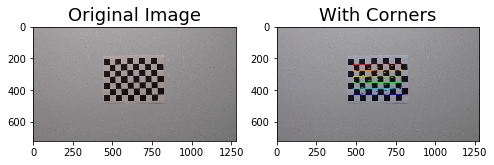

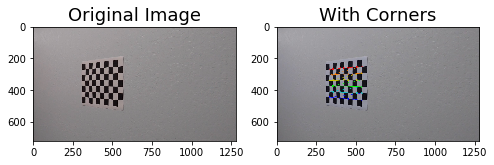

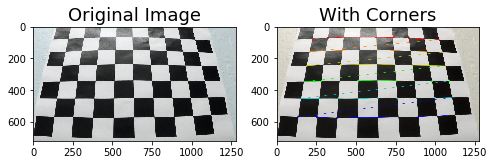

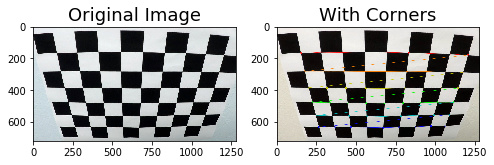

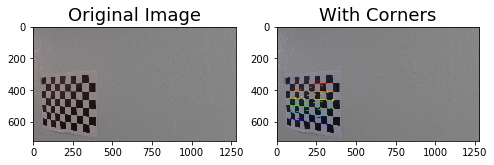

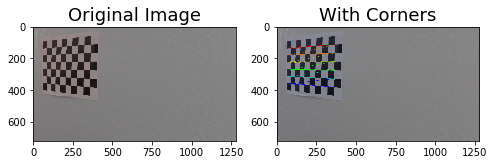

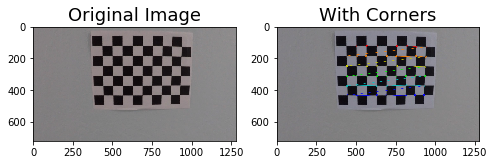

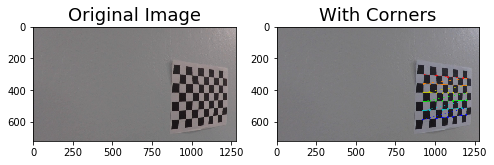

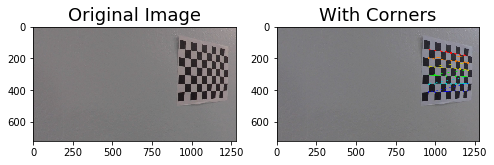

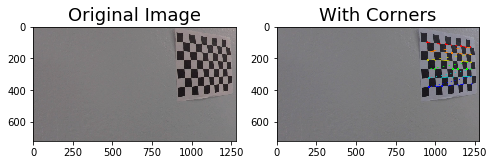

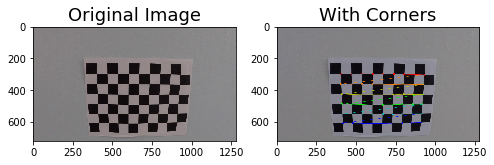

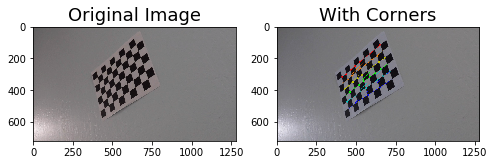

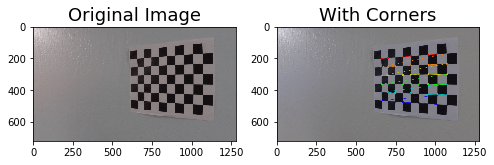

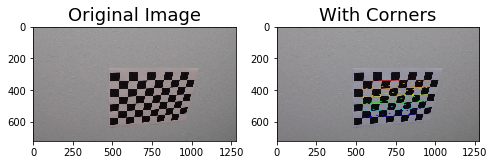

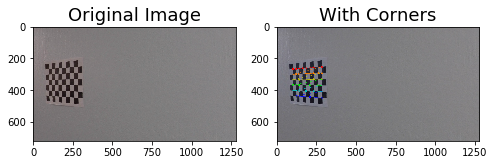

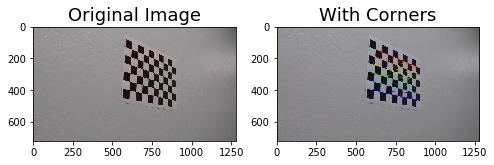

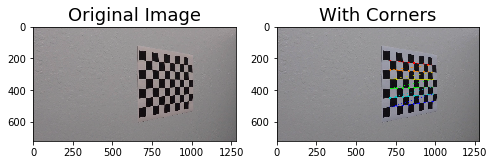

In [4]:
# Prepare object points, ex: (0,0,0), (1,0,0), (2,0,0), ..., (8,5,0)
objp = np.zeros((9*6,3),np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store the object points and image points from all the calibration images.
objpts = [] # 3d points in real world space
imgpts = [] # 2d points in image plane

# Make a list of the calibration images
cal_imgs = glob.glob('camera_cal/calibration*.jpg')

# Cycle through the list and perform chessboard corner search
for fname in cal_imgs:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_size = gray.shape[::-1]
    
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    
    # If found, add object points and image points to arrays
    if ret:
        objpts.append(objp)
        imgpts.append(corners)
        
        # Draw and display the corners on calibration images
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
        ax1.imshow(cv2.cvtColor(mpimg.imread(fname), cv2.COLOR_BGR2RGB))
        ax1.set_title('Original Image', fontsize=18)
        ax2.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax2.set_title('With Corners', fontsize=18)

# Calibrate camera and undistort images

In [8]:
# Remove distortion from images using the correction matrix
def undistort_img(img, display=True, read=True):
    if read:
        img = cv2.imread(img)
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpts, imgpts, img_size, None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    if display:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,6))
        ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax1.set_title('Original Image', fontsize=20)
        ax2.imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
        ax2.set_title('Undistorted Image', fontsize=20)
    else:
        return undist

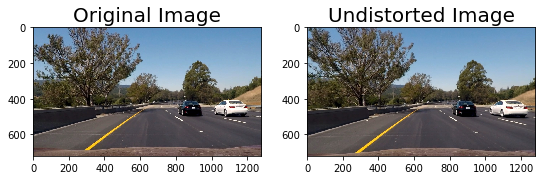

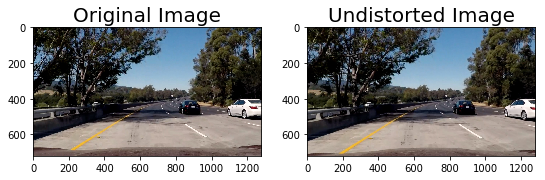

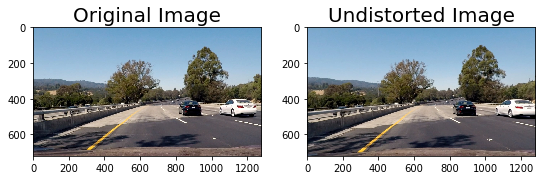

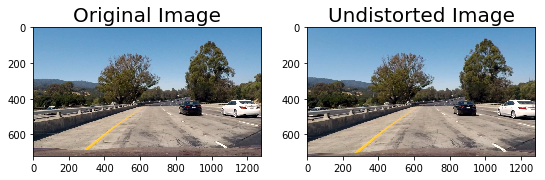

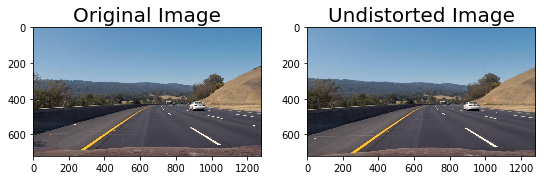

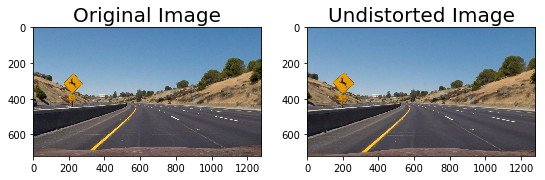

In [9]:
images = glob.glob('test_images/test*.jpg')
for image in images:
    undistort_img(image)

Perspective Transform. To top view.

In [10]:
# Perform perspective transform
def transform_img(img, display=True, read=True):
    if read:
        undist = undistort_img(img, display=False)
    else:
        undist = undistort_img(img, display=False, read=False) 
    img_size = (undist.shape[1], undist.shape[0])
    
    src = np.float32([[490, 482],[810, 482],
                      [1250, 720],[40, 720]])
    dst = np.float32([[0, 0], [1280, 0], 
                     [1250, 720],[40, 720]])
    M = cv2.getPerspectiveTransform(src, dst)
    warped_img = cv2.warpPerspective(undist, M, img_size)
    
    if display:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 6))
        f.tight_layout()
        ax1.imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
        ax1.set_title('Undistorted Image', fontsize=20)
        ax2.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
        ax2.set_title('Undistorted and Warped Image', fontsize=20)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    else:
        return warped_img, M

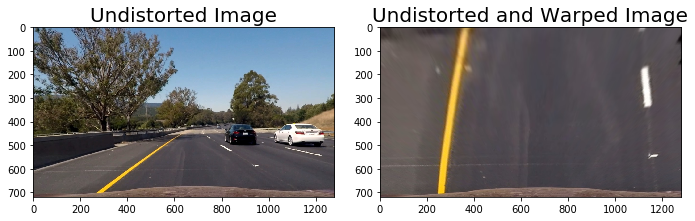

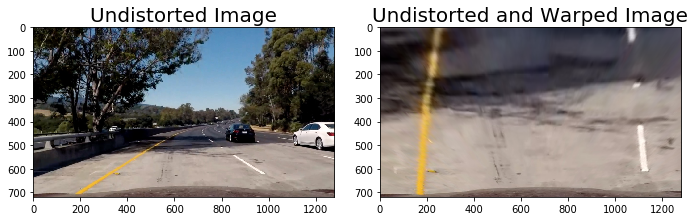

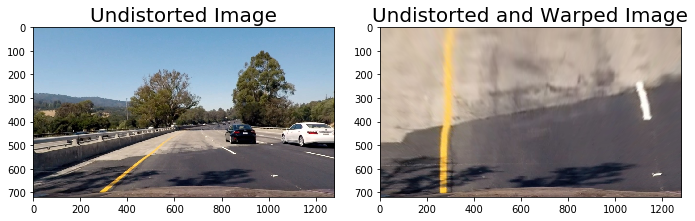

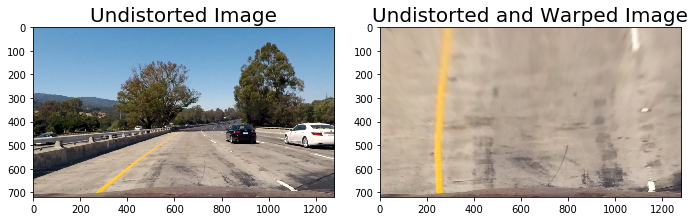

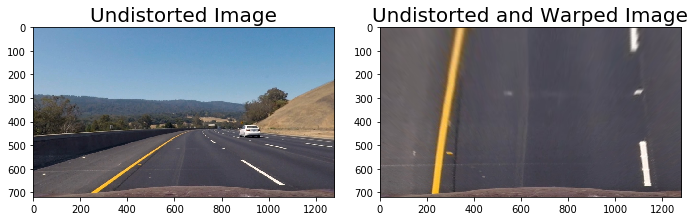

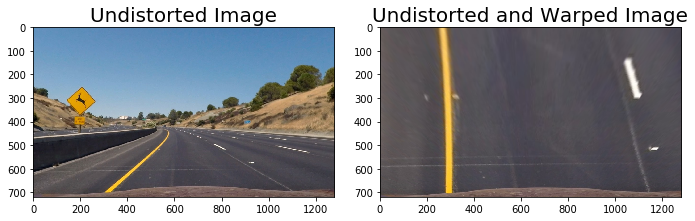

In [11]:
for image in glob.glob('test_images/test*.jpg'):
    transform_img(image)


## Create Threshold Binary Images using undistorted images

In [5]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0,255)):
    xorder = 1
    yorder = 0
    if orient=='y':
        xorder = 0
        yorder = 1
    sobel = cv2.Sobel(img, cv2.CV_64F, xorder, yorder, ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    grad_binary = np.zeros_like(abs_sobel)
    grad_binary[(abs_sobel>thresh[0]) & (abs_sobel<thresh[1])] = 1
    return grad_binary

def mag_thresh(img, sobel_kernel=3, thresh=(0,255)):
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    mag_sobel = np.sqrt(np.square(sobelx) + np.square(sobely))
    mag_binary = np.zeros_like(mag_sobel)
    mag_binary[(mag_sobel>thresh[0]) & (mag_sobel<thresh[1])] = 1
    return mag_binary

def dir_thresh(img, sobel_kernel=3, thresh=(0,255)):
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    dir_sobel = np.arctan2(abs_sobely, abs_sobelx)
    dir_binary = np.zeros_like(dir_sobel)
    dir_binary[(dir_sobel>thresh[0]) & (dir_sobel<thresh[1])] = 1
    return dir_binary

#image = cv2.imread('test_images/signs_vehicles_xygrad.png')
#gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

gray = cv2.cvtColor(undist_imgs[0], cv2.COLOR_BGR2GRAY)

ksize = 5
thresh = (90,180)

gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh=thresh)
grady = abs_sobel_thresh(gray, orient='y', sobel_kernel=ksize, thresh=thresh)
mag_binary = mag_thresh(gray, sobel_kernel=ksize, thresh=thresh)
dir_binary = dir_thresh(gray, sobel_kernel=ksize, thresh=(0, np.pi/2))

combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

cv2.imshow('output', combined)
cv2.waitKey()
cv2.destroyAllWindows()
